In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
# import whenever 
import glob
import os
import pytz
from timezonefinder import TimezoneFinder

In [2]:
# Import site metadata csv
timedelta = 'DD'

filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

## Import FluxNet Data

In [23]:
# Import selected site daily subset data
timedelta = 'DD'

site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values


filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + convert to datetime objects    
fluxnet_sel_sub = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
fluxnet_sel_sub['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_sub['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_sub = fluxnet_sel_sub.set_index('TIMESTAMP')

# Convert units
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_sub['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_sub['NEE_VUT_REF']*1e-6*12.01*1e-3
fluxnet_sel_sub.head()

,NEE_VUT_REF,NEE_VUT_REF_QC,GPP_NT_VUT_REF,GPP_DT_VUT_REF,FluxNET NEE (kgC m-2 s-1)
TIMESTAMP,,,,,
2001-01-01,1.72459,0.0,-1.592180,3.88356,2.071233e-08
2001-01-02,1.44988,0.0,-1.218270,4.37163,1.741306e-08
2001-01-03,1.58019,0.0,-0.922631,4.54447,1.897808e-08
2001-01-04,1.72459,0.0,-0.926978,4.33976,2.071233e-08
2001-01-05,1.44988,0.0,-0.636165,4.60081,1.741306e-08


## NEE

In [4]:
# Function to obtain NEE data
def get_NEE_data(site_ID):
    ## Fluxnet Data 
    # Import selected site daily subset data
    timedelta = 'DD'
    
    site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
    

    filepath = 'ameriflux-data/'
    sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects    
    fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
    fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

    # Convert units
    # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
    fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    
    # Mask bad QC values
    fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'].mask(fluxnet_sel_simple['NEE_VUT_REF_QC'] < 1, np.nan)
    
    # Import simplified MiCASA from data-extract.py
    dir = 'output'
    filename = f'{site_ID}_micasa_NEE_{timedelta}.csv'
    path = os.path.join(dir, filename)
    micasa_ds = pd.read_csv(path,index_col=0)
    micasa_ds.index = pd.to_datetime(micasa_ds.index)
    
    # Append together
    plot_ds = micasa_ds.merge(fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'],left_index=True, right_index=True)
    return plot_ds

In [5]:
# Function to plot data (no widget)
def hv_plot_data(dataset):
    # Define misc plotting variables
    datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
    # months='%b %Y %H:%M')

    plot = dataset.hvplot(
        width=1200,height=500,
        label='Fluxnet',
        xlabel='time',
        xformatter= datetimeformatter,
        yformatter='%.1e',
        ylabel = 'NEE (kg C m-2 s-1)',
        title = f'{site_ID} (Daily Averages)',
        legend='bottom',
        grid=True,
    ).opts(legend_position='bottom_left')
    return plot

In [6]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

In [7]:
# Pick a site
site_ID = 'US-Ne1'

In [8]:
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
411,US-Ne1,Mead - irrigated continuous maize site,"Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.","Humid Continental: humid with severe winter, no dry season, hot summer",361.0,"2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020"


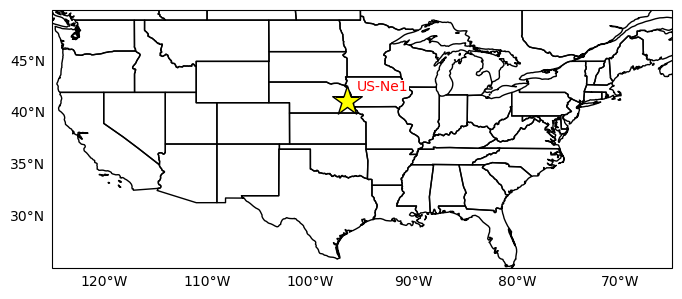

In [9]:
# Plot sites
proj=ccrs.PlateCarree()

# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(8,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)


site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

ax.scatter(site_lon,site_lat,
       marker='*', 
       s=500,
       color='yellow',
       edgecolor='black', zorder=3)
ax.annotate(site_ID, (site_lon + 1,site_lat+1),
            color='red',
            bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                     )

           )

gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [10]:
Ne1_NEEdata = get_NEE_data(site_ID)

In [11]:
hv_plot_data(Ne1_NEEdata)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [12]:
Ne1_subset = Ne1_NEEdata[Ne1_NEEdata.index >= '2018-01-01']
Ne1_subset

,MiCASA NEE (kg m-2 s-1),FluxNET NEE (kgC m-2 s-1)
time,,
2018-01-01,5.900104e-09,4.787042e-09
2018-01-02,6.407336e-09,1.909914e-09
2018-01-03,8.979526e-09,4.479274e-09
2018-01-04,7.850303e-09,NaN
2018-01-05,8.443805e-09,5.356424e-09
...,...,...
2020-12-27,1.045968e-08,1.194286e-08
2020-12-28,8.968748e-09,8.519846e-09
2020-12-29,8.817957e-09,8.329367e-09


In [13]:
hv_plot_data(Ne1_subset)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

## NPP

In [14]:
# # Function to obtain NPP data
# def get_NPP_data(site_ID):
#     ## Fluxnet Data 
#     # Import selected site daily subset data
#     timedelta = 'DD'
    
#     site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
#     site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
    

#     filepath = 'ameriflux-data/'
#     sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
#     fluxnet_sel = pd.read_csv(sel_file)

#     # select subset of columns + convert to datetime objects    
#     fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
#     fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
#     fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

#     # Convert units
#     # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
#     fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    
#     # Mask bad QC values
#     fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'].mask(fluxnet_sel_simple['NEE_VUT_REF_QC'] < 1, np.nan)
    
#     # Import simplified MiCASA from data-extract.py
#     dir = 'output'
#     filename = f'{site_ID}_micasa_NEE_{timedelta}.csv'
#     path = os.path.join(dir, filename)
#     micasa_ds = pd.read_csv(path,index_col=0)
#     micasa_ds.index = pd.to_datetime(micasa_ds.index)
    
#     # Append together
#     plot_ds = micasa_ds.merge(fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'],left_index=True, right_index=True)
#     return plot_ds

In [17]:
# Ne1_NPPdata = get_NPP_data(site_ID)

In [19]:
# Ne1_NPPdata.head()

In [ ]:
# hv_plot_data(Ne1_NPPdata)

In [20]:
## Fluxnet Data 
# Import selected site daily subset data
timedelta = 'DD'

site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values


filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
fluxnet_sel = pd.read_csv(sel_file)


# select subset of columns + convert to datetime objects    
fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')


In [21]:
fluxnet_sel.head()

,TIMESTAMP,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F,SW_IN_F_QC,LW_IN_F,LW_IN_F_QC,VPD_F,VPD_F_QC,...,RECO_DT_VUT_REF,RECO_DT_VUT_25,RECO_DT_VUT_50,RECO_DT_VUT_75,GPP_DT_VUT_REF,GPP_DT_VUT_25,GPP_DT_VUT_50,GPP_DT_VUT_75,RECO_SR,RECO_SR_N
0,20010101,-17.518,0.0,152.441,88.080,0.0,210.896,0.0,0.029,0.0,...,0.003597,0.003610,0.019293,1.38591,3.88356,3.45427,3.87332,6.34230,-9999,-9999
1,20010102,-12.538,0.0,153.067,101.637,0.0,229.734,0.0,0.114,0.0,...,0.038221,0.038221,0.081994,1.78930,4.37163,3.89527,4.36549,7.15950,-9999,-9999
2,20010103,-3.315,0.0,153.753,106.607,0.0,236.822,0.0,0.652,0.0,...,0.216346,0.216345,0.330390,2.48487,4.54447,4.05186,4.53998,7.45012,-9999,-9999
3,20010104,-0.759,0.0,154.497,101.357,0.0,252.907,0.0,1.108,0.0,...,0.438231,0.355152,0.523638,2.64357,4.33976,3.86809,4.33462,7.11088,-9999,-9999
4,20010105,0.516,0.0,155.300,107.976,0.0,241.655,0.0,1.301,0.0,...,0.430434,0.373392,0.546948,2.73952,4.60081,4.10221,4.59636,7.54283,-9999,-9999
